In [31]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import scipy.stats as stats

# Project 1

### Task 1

Use the following probability matrix:
$$
\mathbf{P}=\left[\begin{array}{ccccc}
0.9915 & 0.005 & 0.0025 & 0 & 0.001 \\
0 & 0.986 & 0.005 & 0.004 & 0.005 \\
0 & 0 & 0.992 & 0.003 & 0.005 \\
0 & 0 & 0 & 0.991 & 0.009 \\
0 & 0 & 0 & 0 & 1
\end{array}\right]
$$

Assume that one time step equals one month. Simulate 1000 women, all
starting in state 1, until death. Summarize the lifetime distribution of the
women, after surgery, for example using a histogram. In what proportion of
women does the cancer eventually reappear, locally?

**Solution**

In [32]:
P = np.array([[0.9915, 0.005, 0.0025, 0,     0.001],
              [0     , 0.986, 0.005,  0.004, 0.005],
              [0     ,0     , 0.992,  0.003, 0.005],
              [0     ,0     , 0,      0.991, 0.009],
              [0     ,0     , 0,      0,     1    ]])

# Probility of stating in the same state is along the diagonal
# Columns:
state_dict = {'no_tumor': 0,
              'local_recurrence': 1,
              'distant_metastatis': 2,
              'local_and_distant': 3,
              'death': 4}

Local recurrence rate: 79.70%


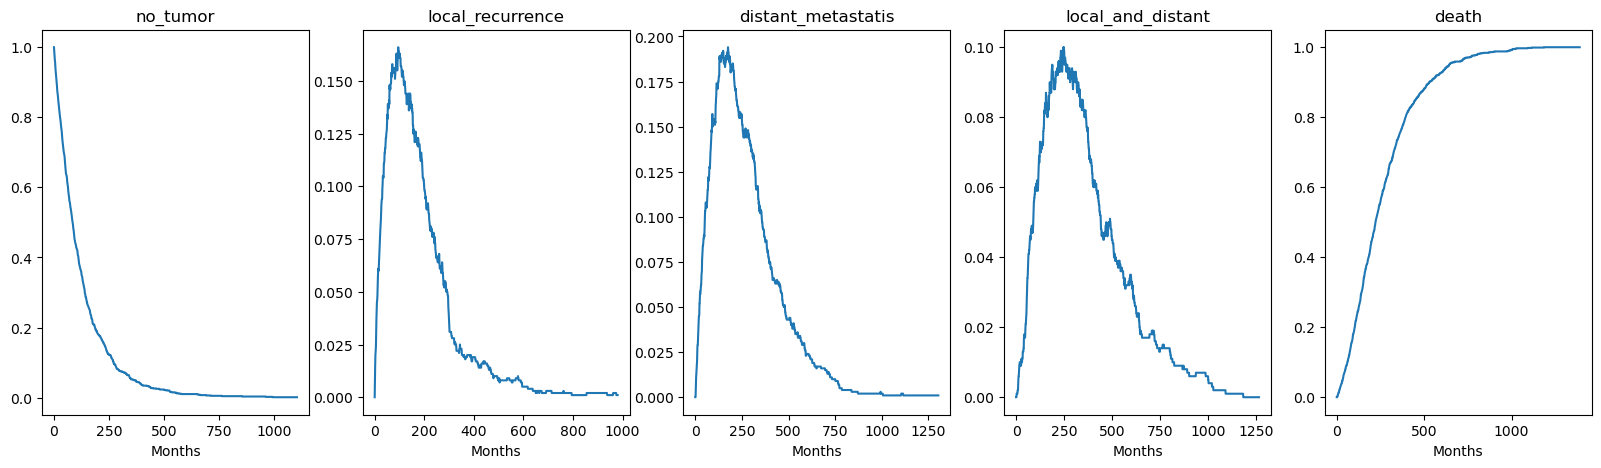

In [33]:
iterations = 1000
n_woman = 1000
states = np.zeros(1000, dtype=int)

state_dist = np.zeros((5, 200*12)) # 200 years

local_recurrence_counter = 0
t = 0
for i in range(iterations):
     while np.sum(states) < n_woman * state_dict['death']:
          for i, state in enumerate(states):
               
               state_dist[state, t] += 1

               if state == state_dict['death']:
                    continue
               
               new_state = np.random.choice(5, p=P[state])

               # if state is no tumor or distant metastatis, it can go to local recurrence
               if state == state_dict['no_tumor'] or state == state_dict['distant_metastatis']:
                    if new_state == state_dict['local_recurrence'] or new_state == state_dict['local_and_distant']:
                         local_recurrence_counter += 1
                    
               states[i] = new_state
          t += 1
          
state_dist /= iterations

print(f'Local recurrence rate: {local_recurrence_counter / n_woman * 100:.2f}%')

fig, axs = plt.subplots(1, 5, figsize=(20, 5))

for i, ax in enumerate(axs):
     bins = np.argmax(np.argwhere(state_dist[i] > 0))+1
     ax.plot(np.arange(len(state_dist[i,:bins])),state_dist[i,:bins])
     ax.set_title(list(state_dict.keys())[i])
     ax.set_xlabel('Months')
plt.show()


### Task 2

Let $\mathbf{p}_t$ denote the probability distribution over the states at time $t$. This
distribution can be found from the following formula:

$$
\mathbf{p}_t=\mathbf{p}_0\left(\mathbf{P}^t\right)
$$

In your simulations, what is the distribution over the states at $t = 120$?
Does this correspond to what we expect? Answer the question using an
appropriate statistical test.

Chi2: 0.0008794976508940211, p-value: 0.9999999033388266


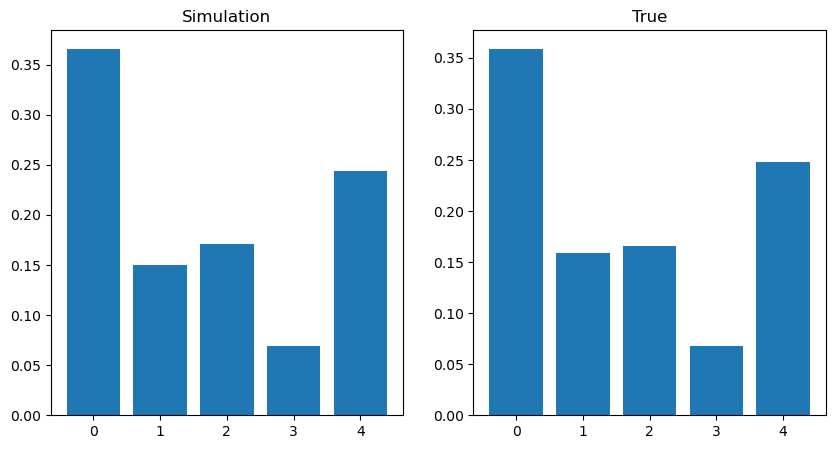

In [34]:
p_120_sim = state_dist[:,120]
p_120_true = (np.array([[1., 0. ,0., 0., 0.]])@np.linalg.matrix_power(P, 120))[0]

# chi2 test
chi2, p = stats.chisquare(p_120_sim, p_120_true)

print(f'Chi2: {chi2}, p-value: {p}')

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].bar(np.arange(5),p_120_sim)
axs[0].set_title('Simulation')
axs[1].bar(np.arange(5),p_120_true)
axs[1].set_title('True')
plt.show()


### Task 3

The above approach only validates the simulation at a certain time point. A
better approach is to ensure the emperical lifetime distribution matches the
theoretical.
It can be shown that the lifetime, $T$, follows a so-called discrete phase-type
distribution. This distribution has probability mass function

$$P(T=t)=\boldsymbol{\pi}\left(\mathbf{P}_{\mathrm{s}}\right)^t \mathbf{p}_{\mathbf{s}}$$

and mean

$$E(T)=\boldsymbol{\pi}\left(\mathbf{I}-\mathbf{P}_s\right)^{-1} \mathbf{1}$$

Where $\boldsymbol{\pi}$ is the distribution over states $1, 2, 3, 4$ at $t = 0$. $\mathbf P_s$ is a $4\times 4$
sub-matrix of $\mathbf P$ formed by removing the last row and column. $\mathbf p_s$ is column
vector indicating the probability of dying from states $1, 2, 3, 4$. $\mathbf 1$ is a vector
of ones of appropriate dimension.

Does your simulated lifetimes follow this distribution?

**Solution:**

KS: 0.27651139742319125, p-value: 2.3623805855277213e-34


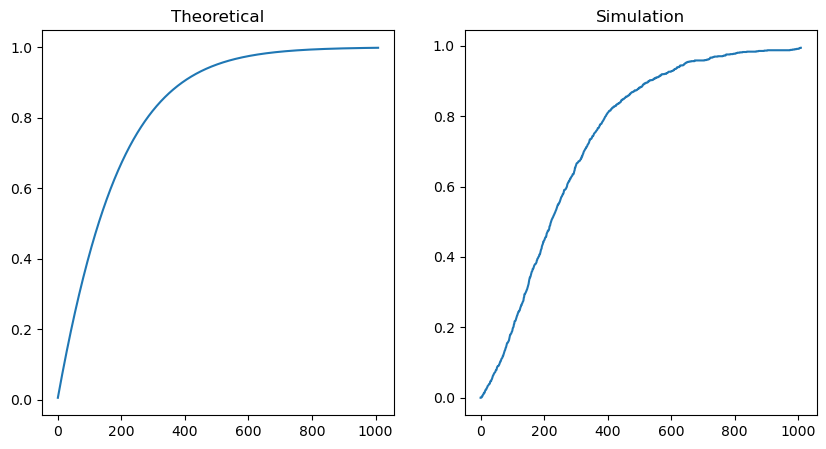

In [46]:
pi = np.zeros((1,4))
pi[0] = 1

Ps = P[:4,:4]
ps = P[:4,-1][None,...]

phase_type_dist = lambda t : (pi@np.linalg.matrix_power(Ps, t)@ps.T).item()
phase_type_mean = pi*np.linalg.inv(np.identity(4) - Ps)@np.ones((4,1))

bins = np.argmax(np.argwhere(state_dist[-1,1:] == 0))+1
death_dist_pred = state_dist[-1,:bins]
death_pred_true = np.array([phase_type_dist(t) for t in range(bins)])

#fig, axs = plt.subplots(1, 2, figsize=(10, 5))
#axs[0].plot(np.arange(bins),death_dist_pred)
#axs[0].set_title('Simulation')
#axs[1].plot(np.arange(bins),death_pred_true)
#axs[1].set_title('True')
#plt.show()

# the true function is the probability of being in the death state at time t

cumulative_death_dist_true = np.cumsum(death_pred_true) / 4

# plot the results
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].plot(np.arange(bins),cumulative_death_dist_true)
axs[0].set_title('Theoretical')
axs[1].plot(np.arange(bins),death_dist_pred)
axs[1].set_title('Simulation')

# ks test
ks, p = stats.ks_2samp(cumulative_death_dist_true, death_dist_pred)
print(f'KS: {ks}, p-value: {p}')

### Task 4

Estimate the expected lifetime, after surgery, of a woman who survives the
first 12 months following surgery, but whose breast cancer has also reappeared within the first 12 months, either locally or distant.

*Hint:* Use rejection sampling. Simulate a number of women, and discard
all simulations that do not meet the requirements. Do this until you have
reached 1000 acceptable simulations.

**Solution:**

Expected lifetime after surgery for acceptable cases: 174.181 months


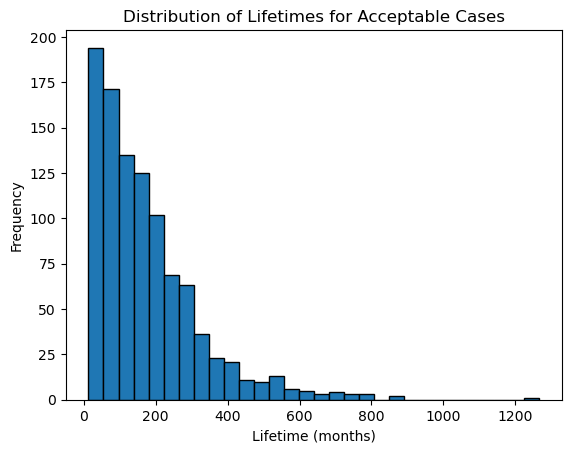

In [49]:
def simulate_lifetime(P, state_dict):
    state = state_dict['no_tumor']
    lifetime = 0
    recurrence = False
    while state != state_dict['death']:
        new_state = np.random.choice(5, p=P[state])
        if lifetime < 12:
            if new_state in [state_dict['local_recurrence'], state_dict['distant_metastatis'], state_dict['local_and_distant']]:
                recurrence = True
        state = new_state
        lifetime += 1
    return lifetime, recurrence

# Use rejection sampling
acceptable_lifetimes = []
iterations = 0
required_samples = 1000

while len(acceptable_lifetimes) < required_samples:
    lifetime, recurrence = simulate_lifetime(P, state_dict)
    if lifetime > 12 and recurrence:
        acceptable_lifetimes.append(lifetime)
    iterations += 1

expected_lifetime = np.mean(acceptable_lifetimes)
print(f'Expected lifetime after surgery for acceptable cases: {expected_lifetime} months')

# plot the distribution of lifetimes for acceptable cases
plt.hist(acceptable_lifetimes, bins=30, edgecolor='black')
plt.title('Distribution of Lifetimes for Acceptable Cases')
plt.xlabel('Lifetime (months)')
plt.ylabel('Frequency')
plt.show()

### Task 5
What fraction of women die within the first 350 months? Answer this by
simulating 200 women, and record the fraction. Do this 100 times. Use control variates to reduce the variance.
How large a reduction in variance do you see, using control variates, as opposed to the crude Monte Carlo estimator?

*Hint:* Use the mean lifetime after surgery of the 200 simulations as the
control variate

**Solution:**

Crude Monte Carlo estimate of fraction: 1.0
Variance of crude estimate: 0.0
Control variates estimate of fraction: 1.0
Variance of control variates estimate: 0.0
Reduction in variance: 0.0


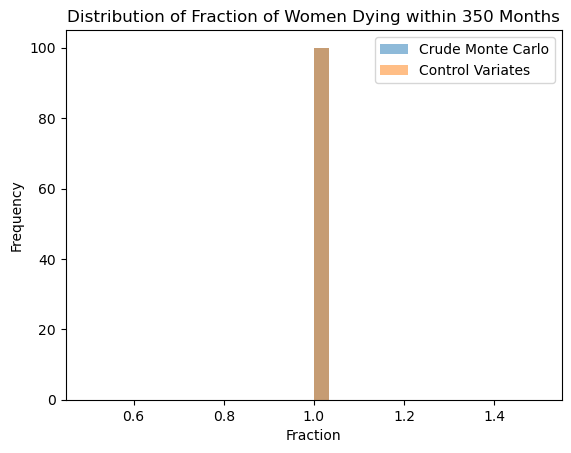

In [50]:
def simulate_lifetime(P, state_dict):
    state = state_dict['no_tumor']
    lifetime = 0
    while state != state_dict['death']:
        new_state = np.random.choice(5, p=P[state])
        state = new_state
        lifetime += 1
        if lifetime >= 350:  # Stop if lifetime exceeds 350 months
            break
    return lifetime

def simulation_200_women(P, state_dict):
    lifetimes = []
    for _ in range(200):
        lifetime = simulate_lifetime(P, state_dict)
        lifetimes.append(lifetime)
    lifetimes = np.array(lifetimes)
    fraction_died_within_350 = np.sum(lifetimes <= 350) / 200
    mean_lifetime = np.mean(lifetimes)
    return fraction_died_within_350, mean_lifetime

# Perform 100 simulations
fractions = []
control_means = []
for _ in range(100):
    fraction, mean_lifetime = simulation_200_women(P, state_dict)
    fractions.append(fraction)
    control_means.append(mean_lifetime)

fractions = np.array(fractions)
control_means = np.array(control_means)

# Crude Monte Carlo estimate
mean_fraction = np.mean(fractions)
variance_crude = np.var(fractions)

# Control variates method
expected_mean_lifetime = np.mean([simulate_lifetime(P, state_dict) for _ in range(1000)])
c = np.cov(fractions, control_means)[0, 1] / np.var(control_means)
adjusted_fractions = fractions - c * (control_means - expected_mean_lifetime)
mean_adjusted_fraction = np.mean(adjusted_fractions)
variance_adjusted = np.var(adjusted_fractions)

# Results
print(f'Crude Monte Carlo estimate of fraction: {mean_fraction}')
print(f'Variance of crude estimate: {variance_crude}')
print(f'Control variates estimate of fraction: {mean_adjusted_fraction}')
print(f'Variance of control variates estimate: {variance_adjusted}')
print(f'Reduction in variance: {variance_crude - variance_adjusted}')

# Optionally, plot the results
plt.hist(fractions, bins=30, alpha=0.5, label='Crude Monte Carlo')
plt.hist(adjusted_fractions, bins=30, alpha=0.5, label='Control Variates')
plt.title('Distribution of Fraction of Women Dying within 350 Months')
plt.xlabel('Fraction')
plt.ylabel('Frequency')
plt.legend()
plt.show()

### Task 6

For the report, consider the following questions: What assumptions underlie
the discrete time Markov chain model? Are those assumptions realistic? How
may we relax some of these assumptions, possibly at the cost of increased
model complexity?

**Solution:**

## Part 2: A continuous-time model

*see project text*

### Task 7

As before, we choose one time-unit equal to one month. Use the following
transition-rate matrix:

$$
\mathbf{Q}=\left[\begin{array}{ccccc}
-0.0085 & 0.005 & 0.0025 & 0 & 0.001 \\
0 & -0.014 & 0.005 & 0.004 & 0.005 \\
0 & 0 & -0.008 & 0.003 & 0.005 \\
0 & 0 & 0 & -0.009 & 0.009 \\
0 & 0 & 0 & 0 & 0
\end{array}\right]
$$

Simulate 1000 women, all starting in state 1, until death. Summarize the
lifetime distribution after surgery, for example in a histogram. Report the
mean, along with a confidence interval, and the standard deviation, also
with a confidence interval. In what proportion of women has the cancer
reappeared distantly after 30.5 months?

**Solution:**